## Import libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
from srs.analysis import read_data, plot_missing_values, plot_max_median, plot_correlation_between_stations, \
    remove_outliers, interpolate_missing_values, calculate_mean_value_across_all_stations, save_mean_data, \
    plot_change_between_consecutive_hours, plot_diff_between_stations

## Read data

In [3]:
data = read_data('PM10')
stations = data.columns.tolist()[1:]

In [4]:
stations

['WpPoznDabrow', 'WpPoznRatajeMOB']

In [5]:
data

Time  WpPoznDabrow  WpPoznRatajeMOB
0    2020-01-01 01:00:00       37.3714          28.9952
1    2020-01-01 02:00:00       20.2835          18.6745
2    2020-01-01 03:00:00       20.3019          20.7499
3    2020-01-01 04:00:00       20.4632          20.8281
4    2020-01-01 05:00:00       19.8122          19.0966
...                  ...           ...              ...
8778 2020-12-31 19:00:00           NaN          72.3199
8779 2020-12-31 20:00:00           NaN          85.5207
8780 2020-12-31 21:00:00           NaN         101.3240
8781 2020-12-31 22:00:00           NaN         102.1370
8782 2020-12-31 23:00:00           NaN         108.8390

[8783 rows x 3 columns]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8783 entries, 0 to 8782
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Time             8783 non-null   datetime64[ns]
 1   WpPoznDabrow     7854 non-null   float64       
 2   WpPoznRatajeMOB  8763 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 274.5 KB


In [7]:
data.describe().T

count       mean        std      min        25%       50%  \
WpPoznDabrow     7854.0  23.621556  15.271192  1.75846  12.814725  19.79005   
WpPoznRatajeMOB  8763.0  23.485635  17.691852  1.64488  12.030750  18.58640   

                      75%      max  
WpPoznDabrow     30.35650  143.701  
WpPoznRatajeMOB  29.25435  246.382

### Investigate missing values

In [8]:
data.isnull().mean().round(3)

Time               0.000
WpPoznDabrow       0.106
WpPoznRatajeMOB    0.002
dtype: float64

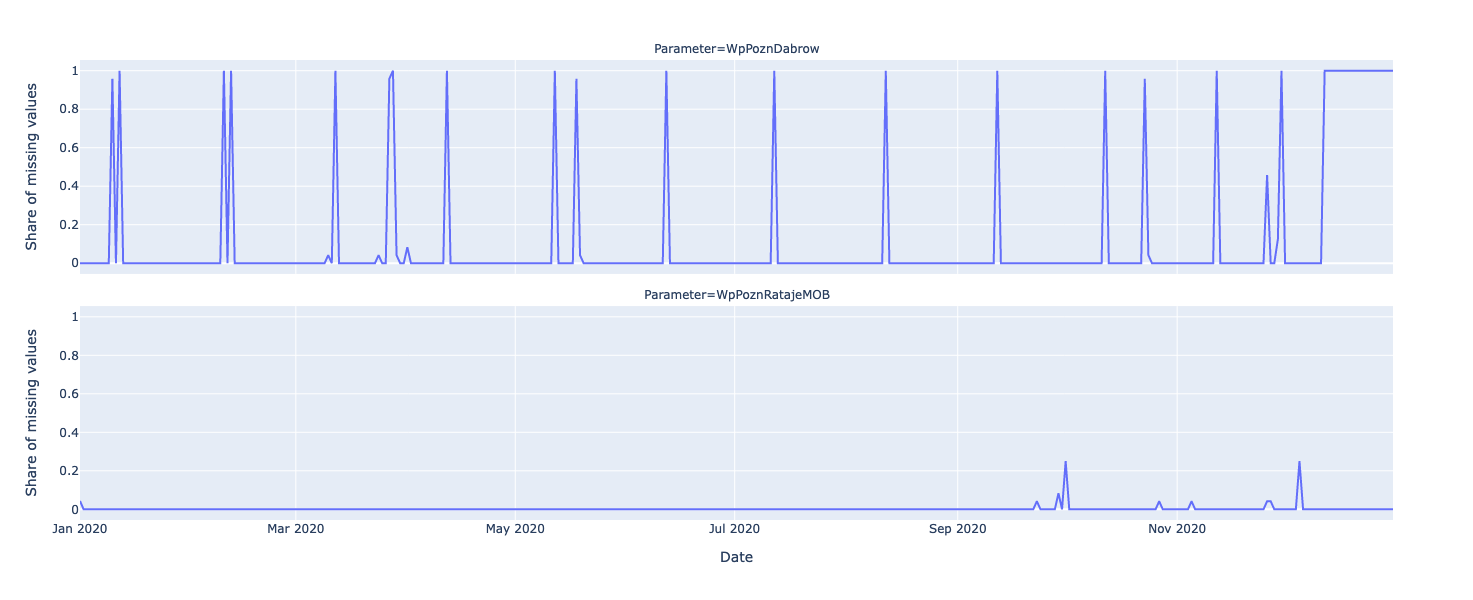

In [9]:
plot_missing_values(data, stations)

There are lots of missing data for the WpPoznDabrow station, it is 10% of values for the data range of analysis. But they are not spread but are rather whole days when the measurement was off. The other station has very little missing values and they probalby can be interpolated easily. 

## EDA

**Maximum and median values**

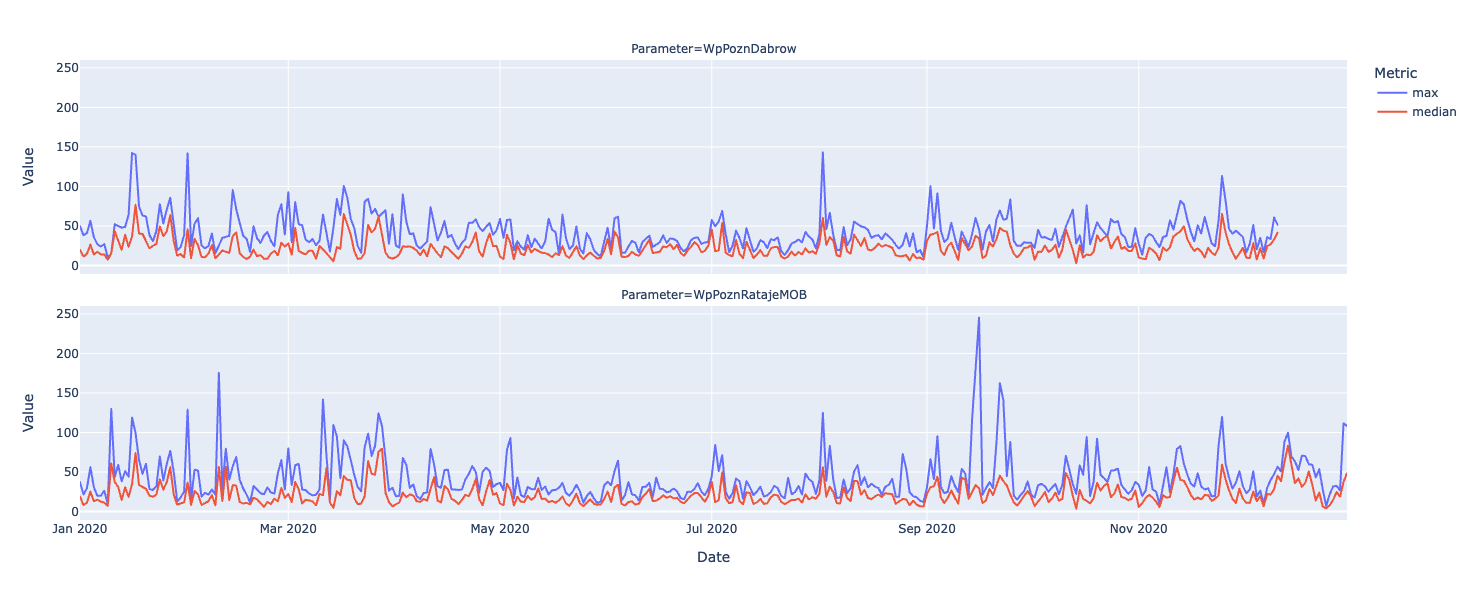

In [10]:
plot_max_median(data, stations)

The station WpPoznRatajeMOB gives very high values a few times during the year which are multiples times higher than the median and are not detected by the other station. They are probably some temporary outliers due to random events near the station which result in higher concentration of pollution. 

**Correlation between stations**

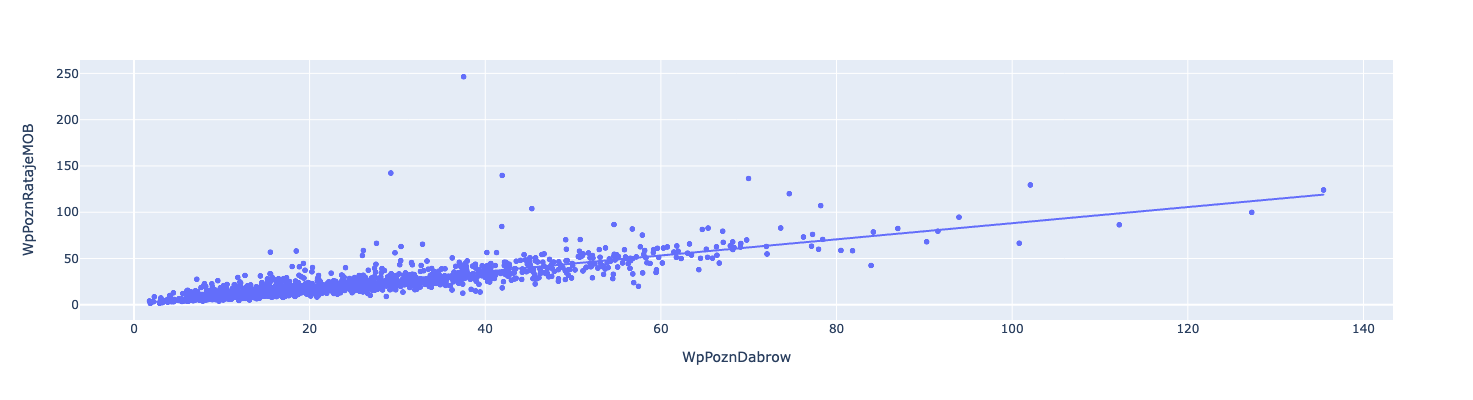

In [11]:
plot_correlation_between_stations(data, stations[0], stations[1])

As expected, due to the fact that the stations are located near each other (within one city) their measurements are highly correlated.

**Change between consecutive hours**

                Difference                              
                      mean    median       max       std
Parameter                                               
WpPoznDabrow     -0.004112 -0.002615   46.5013  4.934664
WpPoznRatajeMOB  -0.015679 -0.024660  215.6908  6.849992


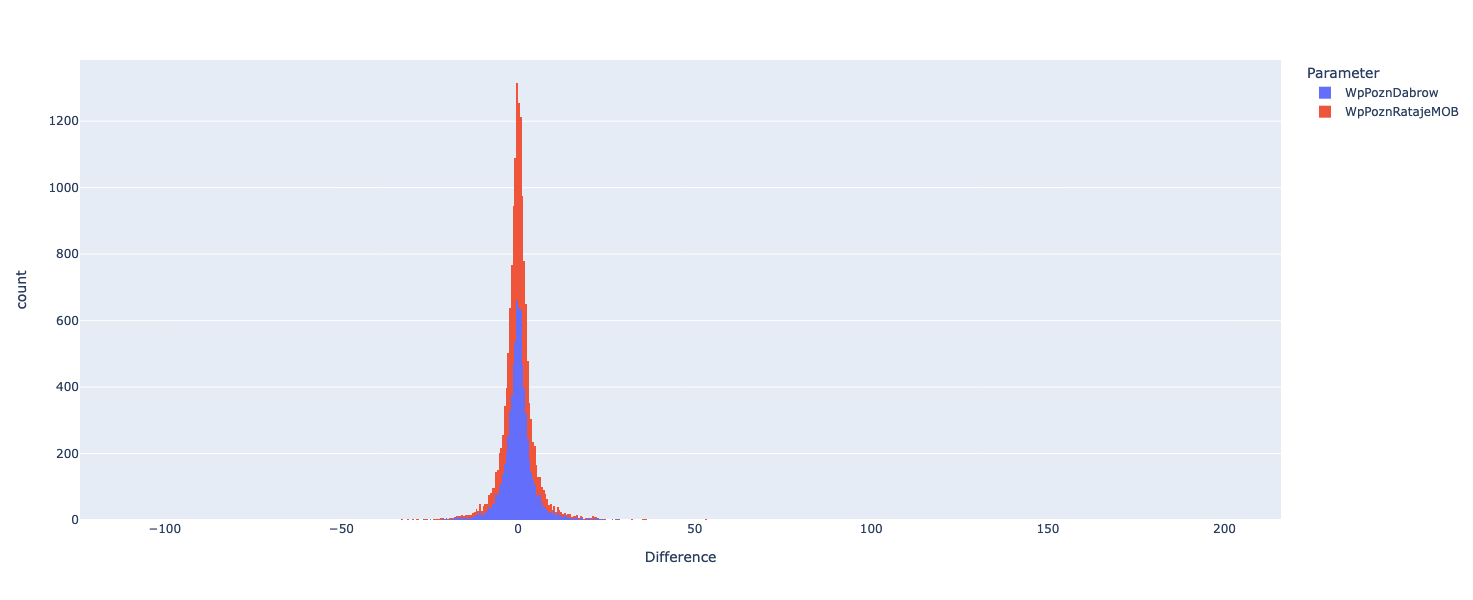

In [12]:
plot_change_between_consecutive_hours(data, stations)

We see that there are rarely any rapid changes that happen within one our. When they happen they are not caused by a recurrent event.

**Difference between stations**

mean       -2.171091
median     -2.297050
max       208.842800
std         8.405863
Name: Difference, dtype: float64


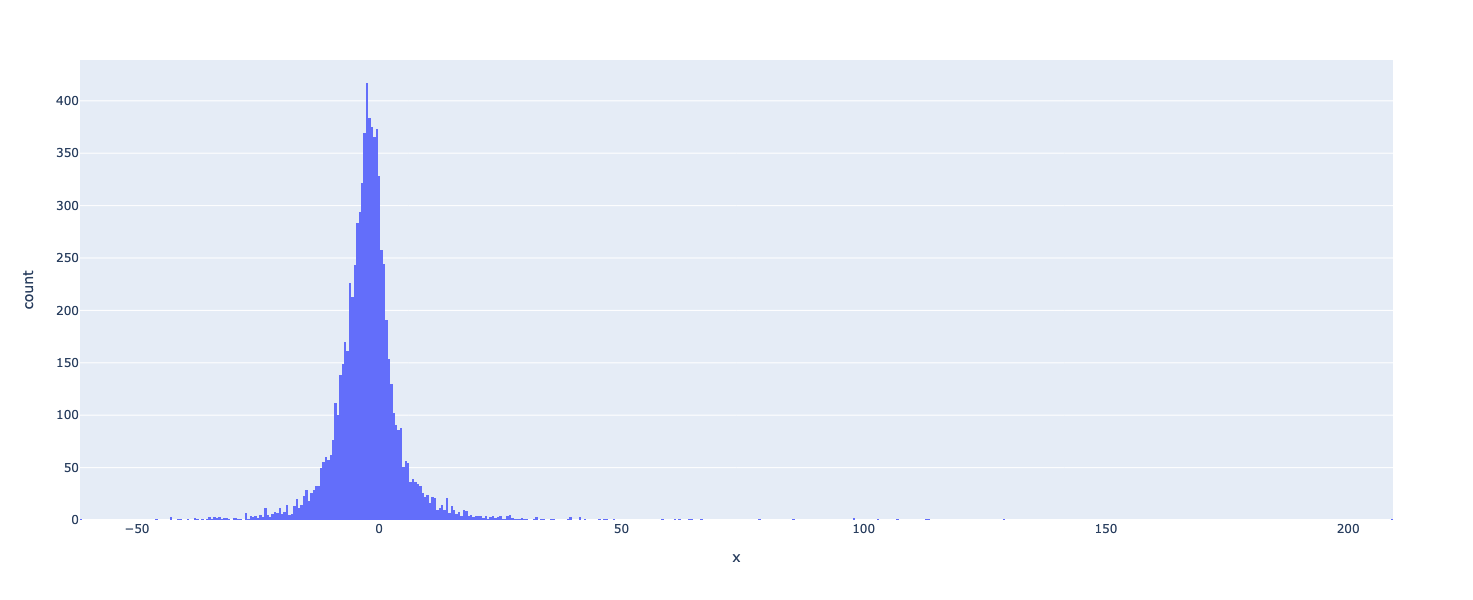

In [13]:
plot_diff_between_stations(data, *stations)

As there is high correlation between the stations, any high difference indicates a random event near one of the stations and we can treat it as an outlier. We can build the story around them (what causes these events? is someone polluting the area and hurt peaple's health?) or remove them to focus on the general trends and recurring pollution events. I decided to choose the later option.

## Remove outliers

In [14]:
data_rm_outliers = remove_outliers(data, stations)
data_rm_outliers = interpolate_missing_values(data_rm_outliers, stations)

20 outliers removed for WpPoznDabrow
31 outliers removed for WpPoznRatajeMOB
38 values interpolated for WpPoznDabrow
45 values interpolated for WpPoznRatajeMOB


In [15]:
data_rm_outliers = remove_outliers(data, stations)
data_rm_outliers = interpolate_missing_values(data_rm_outliers, stations)

20 outliers removed for WpPoznDabrow
31 outliers removed for WpPoznRatajeMOB
38 values interpolated for WpPoznDabrow
45 values interpolated for WpPoznRatajeMOB


The interploation filled missing data only up to 3 concurrent hours and this limit was chosen based on intuiton of the analyst.

How many missing values are left?

In [16]:
data.isnull().sum()

Time                 0
WpPoznDabrow       929
WpPoznRatajeMOB     20
dtype: int64

In [17]:
data_rm_outliers.isnull().sum()

Time                 0
WpPoznDabrow       911
WpPoznRatajeMOB      6
dtype: int64

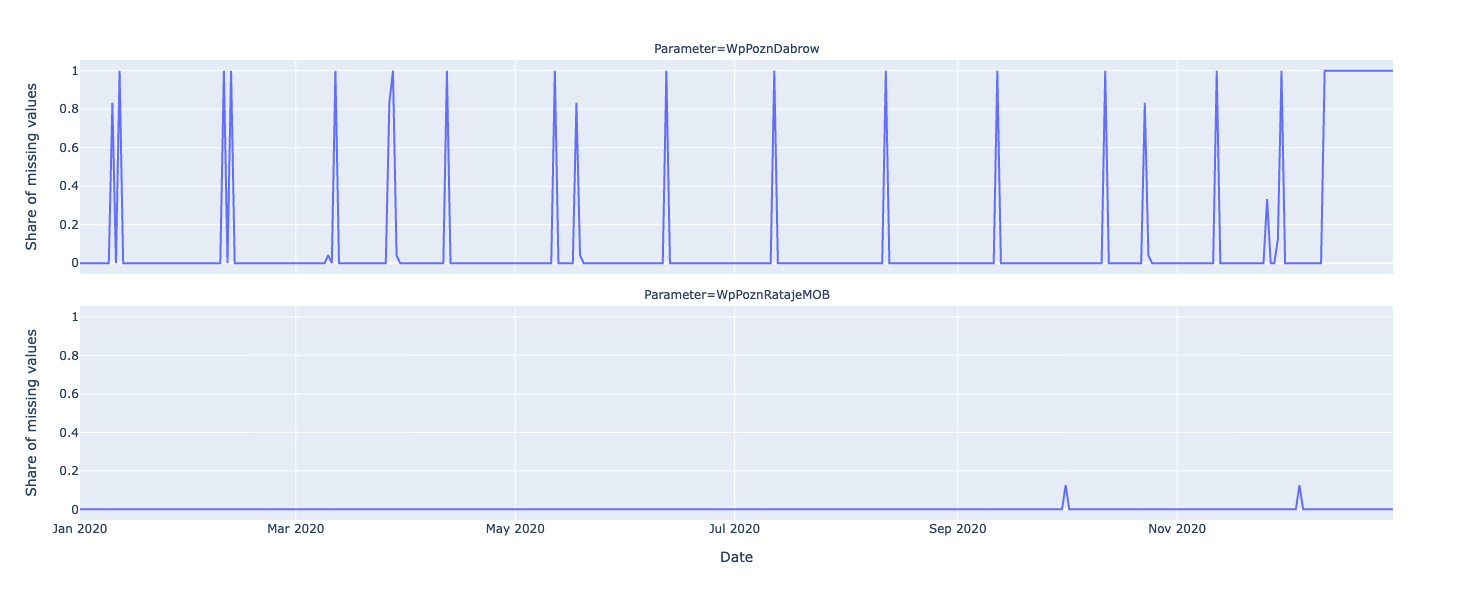

In [18]:
plot_missing_values(data_rm_outliers, stations)

After replacing the outliers with interpolated data the correlation should improve.

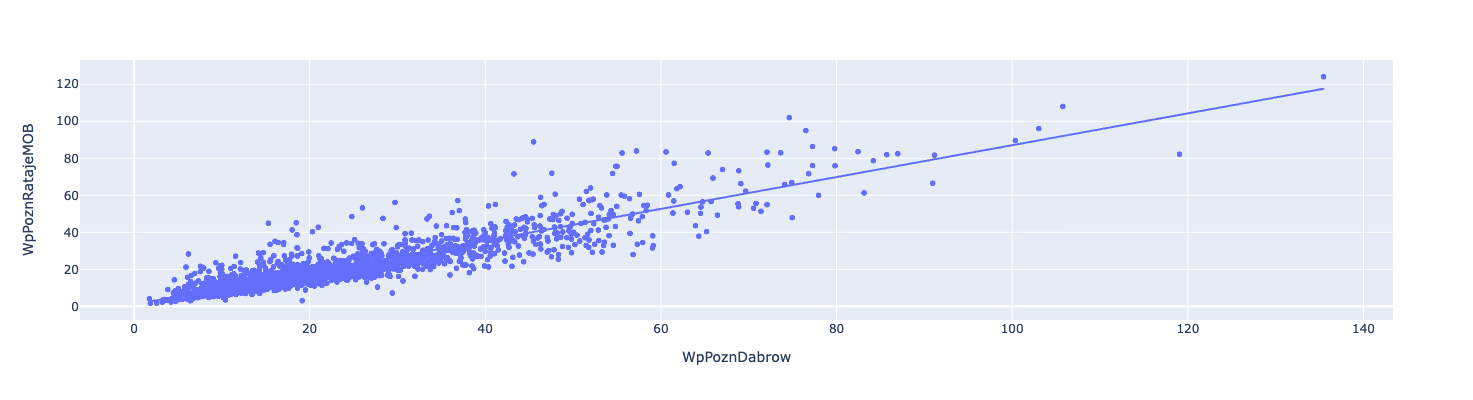

In [19]:
plot_correlation_between_stations(data_rm_outliers, stations[0], stations[1])

## Calculate final mean value across all the stations

In [20]:
data_mean = calculate_mean_value_across_all_stations(data_rm_outliers, 'PM10')

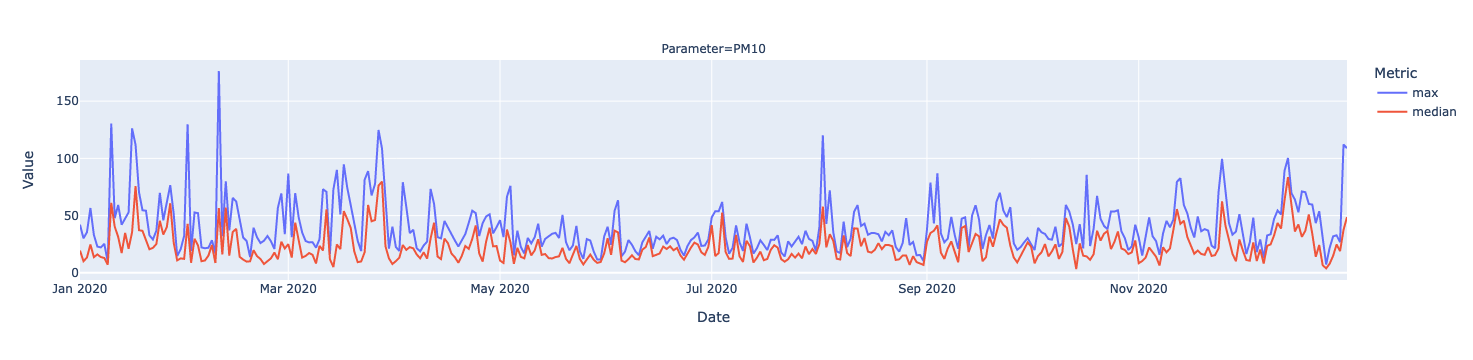

In [21]:
plot_max_median(data_mean, ['PM10'])

In [22]:
data_mean.isnull().sum()

Time    0
PM10    0
dtype: int64

With data from both stations we covered the entire year.

**Save mean data**

In [23]:
save_mean_data(data_mean, 'PM10')